## Analyze A/B Test Results



## Table of Contents
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)




<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [123]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [124]:
df = pd.read_csv('ab_data.csv')

b. Use the cell below to find the number of rows in the dataset.

In [125]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [126]:
len(df.user_id.unique())

290584

d. The proportion of users converted.

In [127]:
df['converted'].mean()

0.11965919355605512

In [128]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


e. The number of times the `new_page` and `treatment` don't match.

In [129]:
len(df.query('group == "control" & landing_page ==  "new_page" ')) + len(df.query('group == "treatment" & landing_page !=  "new_page" '))

3893

f. Do any of the rows have missing values?

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now create a new dataset that meets the correct matches.  Store your new dataframe in **df2**.

In [131]:
df2 = df.query('group == "treatment" & landing_page == "new_page"').append(df.query('group == "control" & landing_page == "old_page"'))

In [132]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [133]:
len(df2.user_id.unique())

290584

In [134]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


b. There is one **user_id** repeated in **df2**.  What is it?

In [135]:
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [136]:
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [137]:
df2 = df2.drop(2893)

In [138]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


a. What is the probability of an individual converting regardless of the page they receive?

In [139]:
df2.converted.sum() / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [140]:
control_converted = df2.query('group == "control" & converted == 1')['converted'].count() / df2.query('group == "control"')['converted'].count()
control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [141]:
treatment_converted = df2.query('group == "treatment" & converted == 1')['converted'].count() / df2.query('group == "treatment"')['converted'].count()
treatment_converted

0.11880806551510564

d. What is the probability that an individual received the new page?

In [142]:
len(df2.query('landing_page == "new_page"'))/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**There is no sufficient evidence that the new treatment page leads to more conversions  as the two conversion rates are near to each other (12.03% for the control group and 11.88% for the treatment group), also it looks that the  pages recived the pages equally.**

<a id='ab_test'></a>
### Part II - A/B Test

#### Null hypotheses
𝑝𝑜𝑙𝑑 >= 𝑝𝑛𝑒𝑤

#### Alternative hypotheses
𝑝𝑜𝑙𝑑 < 𝑝𝑛𝑒𝑤

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [143]:
p_new = df2.query('converted == 1 ')['converted'].count() / df2.shape[0]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [144]:
p_old = df2.query('converted == 1 ')['converted'].count() / df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [145]:
n_new = len(df2.query(' landing_page == "new_page" ')['user_id'].unique())
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [146]:
n_old = len(df2.query(' landing_page == "old_page" ')['user_id'].unique())
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [147]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)]).mean()
new_page_converted 

0.11923473952240038

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [148]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)]).mean()
old_page_converted

0.1183763095942839

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [149]:
p_new - p_old

0.0

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [150]:
p_diffs = []
for _ in range(1000):
    new_page = np.random.choice([1,0] , size = n_new , p =[p_new , (1-p_new)]   ).mean()
    old_page = np.random.choice([1,0] , size = n_old , p =[p_old , (1-p_old)]   ).mean()
    p_diffs.append(new_page - old_page)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

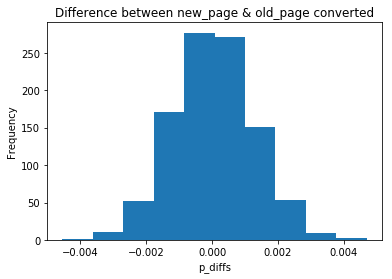

In [151]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Difference between new_page & old_page converted');

In [152]:
treatment_converted - control_converted

-0.0015782389853555567

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [153]:
(p_diffs > (treatment_converted - control_converted)).mean()

0.91900000000000004

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In part j I fiqured that the .886 of the simulated population difference is greater than the actual difference observed in ab_data.csv, this value is called the p-value. As the p-value is large enough, we would fail to reject the Null hypothesis**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [154]:
import statsmodels.api as sm
convert_old = len( df2.query('landing_page == "old_page" & converted == 1 ') )
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [155]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],value=None, alternative='smaller', prop_var=False)

z_score, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score and the p_value mean that we can't reject the Null, so they agree with the findings in parts j and k**

<a id='regression'></a>
### Part III - A regression approach
a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.

In [156]:
df2['intercept'] = 1
df2['treatment'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,treatment
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [157]:
model = sm.Logit(df2['converted'], df2[['intercept','treatment']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [158]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-04-13 22:11 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
treatment    -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

**p-value = 0.1899
Null Hypothesis Pnew = Pold
Alternative Hypothesis Pnew ≠ Pold
The difference is in part II, we performed a one-sided test, where in the logistic regression part, it is two-sided test.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Most of the time it's good to consider other factors to add to the regression model beacuse it may affect our model and leads it to be more accurate**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.
Does it appear that country had an impact on conversion?

In [159]:
df3 = pd.read_csv('countries.csv')
df2 = df2.join(df3.set_index('user_id') , on = 'user_id' )
df2[['CA','UK','US']] = pd.get_dummies(df2['country'])
df2.drop(columns = ['UK'] , inplace = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,treatment,country,CA,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0


In [160]:
model = sm.Logit(df2['converted'], df2[['intercept','treatment','CA','US']])
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-04-13 22:11 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
treatment    -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
US           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
==================================================================

"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [161]:
df2['interaction_US_Treatment'] = df2['US'] * df2['treatment']
df2['interaction_CA_Treatment'] = df2['CA'] * df2['treatment']
df2['intercept'] = 1
model_3 = sm.Logit(df2['converted'],df2[['intercept','treatment','US','CA','interaction_US_Treatment','interaction_CA_Treatment']])
results = model_3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                  Logit              No. Iterations:     6.0000     
Dependent Variable:     converted          Pseudo R-squared:   0.000      
Date:                   2021-04-13 22:11   AIC:                212782.6602
No. Observations:       290584             BIC:                212846.1381
Df Model:               5                  Log-Likelihood:     -1.0639e+05
Df Residuals:           290578             LL-Null:            -1.0639e+05
Converged:              1.0000             Scale:              1.0000     
--------------------------------------------------------------------------
                          Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
intercept                -1.9922   0.0161 -123.4571 0.0000 -2.0238 -1.9606
treatment                 0.0108   0.0228    0.4749 0.6349 -0.0339  0.0555
US                        0.0057   0.0188    0.3057 0.7598 -0.0311  0.0426
CA                       -0.0118   0.0398   -0.2957 0.7674 -0.0899  0.0663
interaction_US_Treatment -0.0314   0.0266   -1.1807 0.2377 -0.0835  0.0207
interaction_CA_Treatment -0.0783   0.0568   -1.3783 0.1681 -0.1896  0.0330
==========================================================================

"""

#### As all the p-values are higher greater than .05, so we have no evidence that the new_page increases the conversion rate as compared to the old_page. Also There is no strong evidence that the countries (US, CA and UK) influence the conversion rate